
# 카메라 스티커앱 만들기
이전 LMS에서는 얼굴 사진에 왕관스티커를 붙여보았는데 이번 프로젝트에서는 고양이 스티커를 붙여보겠다.

- 고양이 수염 이미지 : [링크](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)

---
**프로젝트의 구현 목표**
- 원본에 스티커 사진이 정상적으로 합성시키기
- 이미지 위치계산을 통해 스티커가 어울리게 합성시키기
- 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 예외 상황을 잘 처리하기


---


# 라이브러리

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
from matplotlib.image import imread

스티커를 붙여볼 이미지를 불러오자

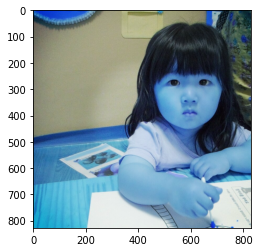

In [5]:
my_image_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/data/2.png' 
img_bgr_original = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr_copy = img_bgr_original.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr_copy)
plt.show()

사진이 잘 로딩되었지만 실제 사진과는 다르게 푸른빛이 많아 차갑게 나왔다. 이것은 opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용하기 때문인데, 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력하는것이다. 따라서 CV이미지를 불러올때는 색보정 작업이 필요하다

참고로 matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB(빨강, 녹색, 파랑) 순으로 사용한다. 

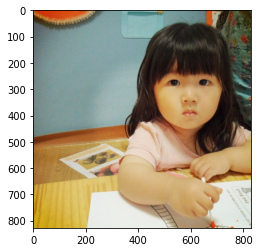

In [6]:
img_rgb = cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# 얼굴 검출(face detection)

dlib의 face detector : [참고](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)
- Object detection 기술
- HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다
 - HOG : 이미지에서 색상의 변화량, 이미지로부터 물체의 특징만 잘 잡아냄
 - SVM : 선형 분류기, 다차원 공간에서 이미지에 대한 벡터를 구분짓는 방법임. 색상만으로 벡터를 구분하기는 어렵고 HOG를 통해 만들어진 벡터에서 잘동작함. 



detector_hog를 이용해서 얼굴의 bounding box를 추출해보자
- 첫번째인자 : dlib은 rgb 이미지를 입력으로 받음
- 두번째인자 : 이미지 피라미드의 수, 
 작게 촬영된 얼굴을 크게 볼수 있게 해주어 정확한 검출이 가능
  - [참고](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

In [7]:
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(489, 217) (712, 440)]]


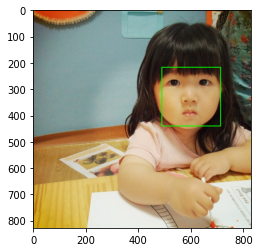

In [8]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_bgr_copy, (l,t), (r,b), (0,255,0), 2 ,  lineType=cv2.LINE_AA)
    
img_rgb_rect = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_rect)

detector_hog 함수는 dlib.rectangles 타입의 객체를 반환하는데 내부 메소드로 left(), top(), right(), bottom(), height(), width()를 통해 검출한 박스에 대한 정보를 얻을 수있다 [link](http://dlib.net/python/index.html#dlib.rectangles)

# 얼굴 랜드마크(Face landmark localization)

face landmark localization : 스티커를 섬세하게 적용하기위해 얼굴의 주요위치(landmark)를 추론하하는 기술. face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용한다.

Object keypoint estimation 알고리즘 :  객체 내부의 점을 찾는 기술
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성


Dlib에 사용 되는 랜드마크 순서


- 랜드마크 점의 개수는 데이셋과 논문마다 다름
Dlib는 [ibug 300-W 데이터셋](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/)으로 학습한 pretrained model을 제공한다

- 참고 : [One Millisecond Face Alignment with an Ensemble of Regression T](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf)


<img src="https://ibug.doc.ic.ac.uk/media/uploads/images/annotpics/figure_68_markup.jpg" 
     style="float: left;  margin-right: 20px; margin-bottom: 20px; width:400px; height:300px;"  ></img>





Dlib의 weight file을 다운받아 bz2의 압축파일을 풀고 작업을 해보자
```
$ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
$ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/project/exp03_CameraStickerApp/models/
$ cd ~/aiffel/project/exp03_CameraStickerApp/models
$ bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
```

In [9]:
model_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환한다.

In [10]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 검출
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_bgr_copy, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 

68


각각의 얼굴마다 68개의 랜드마크가 나왔다.
points 는 dlib.full_object_detection 의 객체로 parts() 함수로 개별 위치정보를 반환한다. 조금 더 직관적인 (x, y) 형태로 변환해 주고 list_points 에 리스트 형태로 저장했다.

랜드 마크를 이미지에 함께 출력해보자

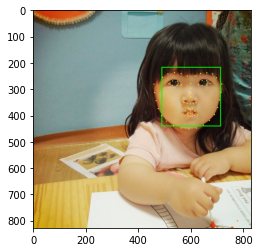

In [11]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_bgr_copy, point, 2, (0, 255, 255), -1)# (0,255,255) BGR중 Green, Red값만 지정 -> yellow

img_rgb_landmarks = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_landmarks)


# 스티커 적용하기
고양이 수염 스티커를 씌울 준비가 되었다. 고양이 수염 스티커의 위치가 중앙에 있어 얼굴이미지에 일단 스티커를 붙여보겠다.
하지만 얼굴각도가 다르게 될경우 바로 적용하는 것은 문제가 있으니 수염 위치 계산시에 이부분을 반영하여 보정해주겠다.


In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    w = h = dlib_rect.width()    
    x = dlib_rect.left()
    y = dlib_rect.top()
    
sticker_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(224, 224, 3)


In [13]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다
sticker_area = img_bgr_copy[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]

얼굴사진 이미지에서 스티커 영역만 읽어온다. 여기에 스티커 이미지 픽셀을 올릴걸이다.

In [14]:
img_bgr_copy[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)

### np.where
np.where 은 조건을 만족하는 인덱스를 찾아주는 함수로 여기에서는 img_sticker의 값이 0인 곳에 고양이 수염픽셀이 있다고 볼수있다. 
따라서 그부분은 img_sticker 적용하고 아닌부분은 sticker_area를 그대로 적용하면 되겠다

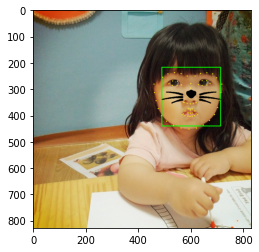

In [15]:
plt.imshow(cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB))

고양이수염이 찰떡같이 맞게 붙었다. bounding box와 landmark를 제거하고 최종 결과만 출력해보자
얼굴검출 박스와 랜드마크가 들어간 img_bgr_copy 이미지가 아닌 원본파일에 고양이 수염이미지를 올리는 코드를 적용하면된다.

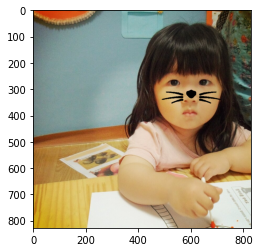

In [16]:
sticker_area = img_bgr_original[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr_original[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB))


---
# 스티커 위치계산

얼굴의 각도가 바뀌거나 할경우 검출박스위에 그대로 스티커를 붙이면 당연히 어색할 것이다.
이제 랜드마크의 위치에 맞게 수염의 방향이나 위치를 재설정하여 적용해보도록하겠다.

In [69]:
my_image_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/data/6_1.jpg' 
img_bgr_original = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr_copy = img_bgr_original.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB)

rectangles[[(92, 316) (315, 539)]]


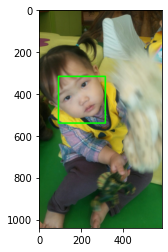

In [70]:
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_bgr_copy, (l,t), (r,b), (0,255,0), 5 ,  lineType=cv2.LINE_AA)
    
img_rgb_rect = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_rect)

68


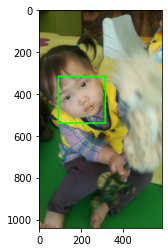

In [71]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 검출
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_bgr_copy, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_bgr_copy, point, 2, (0, 255, 255), -1)# (0,255,255) BGR중 Green, Red값만 지정 -> yellow

img_rgb_landmarks = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_landmarks)

### 각도가 기울어진 얼굴에 처리
위 사진처럼 기울어진 얼굴의 경우 수염 스티커를 회전하는 것이 좋을 것같다. 
회전을 위해 기준이되는 점은 콧망울 옆의 랜드마크인 3번과 15번으로 한다.
두점을 잊는 선과 x축에 사이의 각도를 계산하여 그만큼 고양이 수염 스티커를 회전하여 적용하면 될것 같다

![img](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp03/images/angle.png?raw=true)

In [72]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):      
    w = h = dlib_rect.width()    
    x = dlib_rect.left()
    y = dlib_rect.top()    
    
    x1= landmark[3][0]
    y1 = landmark[3][1] 
    
    x2= landmark[15][0]
    y2 = landmark[15][1] 
    
    print ('3번 랜드마크 (x1,y1) : (%d,%d)'%(x1,y1)) 
    print ('15번 랜드마크(x2,y2) : (%d,%d)'%(x2,y2))  
    

3번 랜드마크 (x1,y1) : (141,521)
15번 랜드마크(x2,y2) : (298,342)


두점 잇는 선과 x축에서의 각도를 구하는 함수를 정의하였다. 

- math.atan(x) : 라디안 x의 아크 탄젠트를 반환

In [73]:
import math

def get_angle(x1,y1, x2,y2):  
    dx = x2-x1
    dy = y2-y1
    print(dx, dy)
    angle = math.atan(dy/dx) * (180.0/math.pi);
    if  dx<0 :
        angle += 180.0
    
    return angle

In [74]:
angle = get_angle(x1,y1, x2,y2) 
print('angle:',angle )

157 -179
angle: -48.746162049603626


위 이미지는 반시계방향으로 48도 정도 기울어져있다. 스티커 이미지를 가져와서 기울어진반큼 회전해보자
아래는 이미지의 회전을 위한 함수이다.

In [75]:
def im_rotate(img, angle): 
    h, w = img.shape[:-1] 
    crossLine = int(((w * h + h * w) ** 0.5)) 
    centerRotatePT = int(w / 2), int(h / 2) 
    new_h, new_w = h, w 
    rotatefigure = cv2.getRotationMatrix2D(centerRotatePT, angle, 1) 
    img2 = cv2.warpAffine(img, rotatefigure, (new_w, new_h))     
    result = cv2.flip(img2,1) # 1은 상하 반전, 0은 좌우 반전
    
    return result

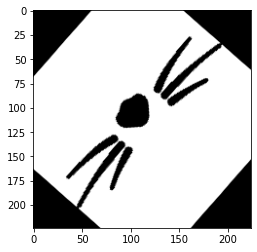

In [76]:
sticker_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) #회전전에 리사이즈

img_angle = im_rotate(img_sticker, angle)

plt.imshow(img_angle)


고양이 수염을 회전시켰다. 이제 원본 사진에 적용해보자!

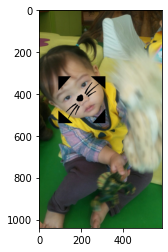

In [77]:
sticker_area = img_bgr_original[y:y+img_angle.shape[0], x:x+img_angle.shape[1]]
img_bgr_original[y:y+img_angle.shape[0], x:x+img_angle.shape[1]] = \
    np.where(img_angle==0,img_angle, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB))

기울어진 각도에 맞게 잘적용되었다. 하지만 고양이 스티커사진이 회전이 되면서 생긴 여백으로 어색하게 스티커가 붙었다.
검정 여백이 남지 않으면서 고양이 수염이 적용되는지는 더 많은 연구가 필요할것 같아 이부분은 여기까지 진행하도록하겠다.

다른 이미지에 추가적으로 고양이 수염이 잘적용되는지 확인해보겠다.

---
# 얼굴각도, 이미지 밝기, 촬영거리 다양한 사진에 스티커 적용하기

### 다른 얼굴각도의 사진

In [78]:
my_image_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/data/6_9.jpg' 
img_bgr_original = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr_copy = img_bgr_original.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB)

rectangles[[(266, 316) (489, 539)]]


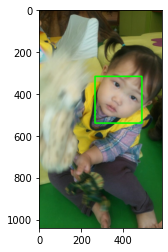

In [79]:
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_bgr_copy, (l,t), (r,b), (0,255,0), 5 ,  lineType=cv2.LINE_AA)
    
img_rgb_rect = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_rect)

68


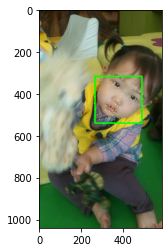

In [80]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 검출
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_bgr_copy, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_bgr_copy, point, 2, (0, 255, 255), -1)# (0,255,255) BGR중 Green, Red값만 지정 -> yellow

img_rgb_landmarks = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_landmarks)

In [81]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):      
    w = h = dlib_rect.width()    
    x = dlib_rect.left()
    y = dlib_rect.top()    
    
    x1= landmark[3][0]
    y1 = landmark[3][1] 
    
    x2= landmark[15][0]
    y2 = landmark[15][1] 
    
    print ('3번 랜드마크 (x1,y1) : (%d,%d)'%(x1,y1)) 
    print ('15번 랜드마크(x2,y2) : (%d,%d)'%(x2,y2))  
   
angle = get_angle(x1,y1, x2,y2) 
print('angle:',angle )

3번 랜드마크 (x1,y1) : (265,413)
15번 랜드마크(x2,y2) : (476,478)
211 65
angle: 17.121808482004507


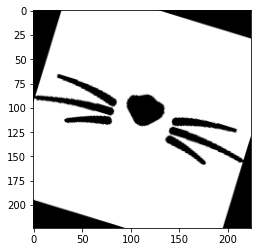

In [82]:
sticker_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) #회전전에 리사이즈

img_angle = im_rotate(img_sticker, angle)
plt.imshow(img_angle)


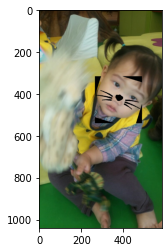

In [83]:
sticker_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) #회전전에 리사이즈

img_angle = im_rotate(img_sticker, angle)

plt.imshow(img_angle)


sticker_area = img_bgr_original[y:y+img_angle.shape[0], x:x+img_angle.shape[1]]
img_bgr_original[y:y+img_angle.shape[0], x:x+img_angle.shape[1]] = \
    np.where(img_angle==0,img_angle, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB))

### 어두운 배경의 사진

rectangles[[(296, 282) (425, 411)]]
68


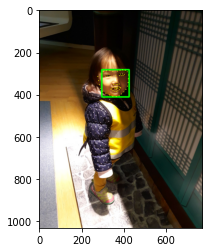

In [88]:
my_image_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/data/6_6.jpg' 
img_bgr_original = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_bgr_copy = img_bgr_original.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB)

dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_bgr_copy, (l,t), (r,b), (0,255,0), 5 ,  lineType=cv2.LINE_AA)
    
img_rgb_rect = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)

list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 검출
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_bgr_copy, dlib_rect)
    list_points = list(map(lambda p:(p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_bgr_copy, point, 2, (0, 255, 255), -1)# (0,255,255) BGR중 Green, Red값만 지정 -> yellow

img_rgb_landmarks = cv2.cvtColor(img_bgr_copy, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_landmarks)

3번 랜드마크 (x1,y1) : (290,370)
15번 랜드마크(x2,y2) : (421,325)
131 -45
angle: -18.958183405106194


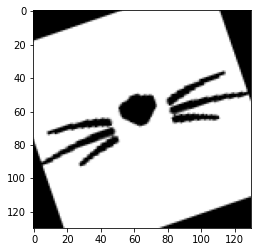

In [89]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):      
    w = h = dlib_rect.width()    
    x = dlib_rect.left()
    y = dlib_rect.top()    
    
    x1= landmark[3][0]
    y1 = landmark[3][1] 
    
    x2= landmark[15][0]
    y2 = landmark[15][1] 
    
    print ('3번 랜드마크 (x1,y1) : (%d,%d)'%(x1,y1)) 
    print ('15번 랜드마크(x2,y2) : (%d,%d)'%(x2,y2))  
   
angle = get_angle(x1,y1, x2,y2) 
print('angle:',angle )

sticker_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) #회전전에 리사이즈

img_angle = im_rotate(img_sticker, angle)
plt.imshow(img_angle)

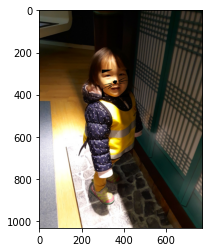

In [90]:
sticker_path = os.getenv('HOME')+'/aiffel/project/exp03_CameraStickerApp/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) #회전전에 리사이즈

img_angle = im_rotate(img_sticker, angle)

plt.imshow(img_angle)


sticker_area = img_bgr_original[y:y+img_angle.shape[0], x:x+img_angle.shape[1]]
img_bgr_original[y:y+img_angle.shape[0], x:x+img_angle.shape[1]] = \
    np.where(img_angle==0,img_angle, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr_original, cv2.COLOR_BGR2RGB))

---
# 정리
이번과제는 머신러닝 라이브러리를 활용하는 부분에 초점을 맞추고 진행해보았다. 이번과제를 통해 알게된을 정리해보자면 아래와 같다.

1) dlib의 face detector를 활용해 얼굴을 감지하는 기술
2) 이미지 배열의 인덱싱 처리
3) OpenCV 라이브러리의 활용 : 이미지의 회전, 이미지 리사이즈등의 API
4) 두이미지를 합성하는 방법

부족한점은 너무 많았다. 실제로 이미지 배열의 인덱싱을 잘못계산하여 무수한 out of Index 에러를 양산해서 과제를 마무리하는시간이 너무 오래걸렸다. 알고리즘을 제대로 만든후 접근하는것이 시행착오를 줄이는 길임을 다시알게되었다. 
그리고 스티커를 회전하여 합성하는 부분이 미완성으로 남아 여러모로 아쉬운 프로젝트이다 


---
# Reference

- 얼굴 인식(Face Recognition) : [link](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c)
- 선이 이루는 각도 구하기 : [link](http://www.gisdeveloper.co.kr/?p=1455)
- 이미지 각도 회전 : [link](https://ansan-survivor.tistory.com/954)